The actual concrete compressive strength (MPa) for a given mixture under aspecific age (days) was determined from laboratory. Data is in raw form (not scaled).The data has 8 quantitative input variables, and 1 quantitative output variable, and 1030 instances (observations).Context:Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.

# Summary of steps taken and performance achieved:
Multiple models with different levels of complexity were attempted. The dependent and independent variables seem to have a nonlinear relationship as the performance of models improved with increasing complexity. MAPE was selected as the evaluation metric.Regularization, feature selection and hyper-parameter tuning was employed to improve the model performance. The models attempted are
1. Linear Regression with no regularization
2. Ridge and Lasso
3. Gradient Boosting
4. Random Forest
5. XGboost
6. Support Vector Machine
7. Stacking - ensemble of the best estimators of the above tuned models with a meta regressor (i.e. Ridge) which gave the best result (MAPE of less than 10)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge,LassoCV, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from matplotlib.pylab import rcParams

In [2]:
df=pd.read_csv("concrete.csv")
df.dtypes ,  df.shape

(cement          float64
 slag            float64
 ash             float64
 water           float64
 superplastic    float64
 coarseagg       float64
 fineagg         float64
 age               int64
 strength        float64
 dtype: object, (1030, 9))

In [200]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

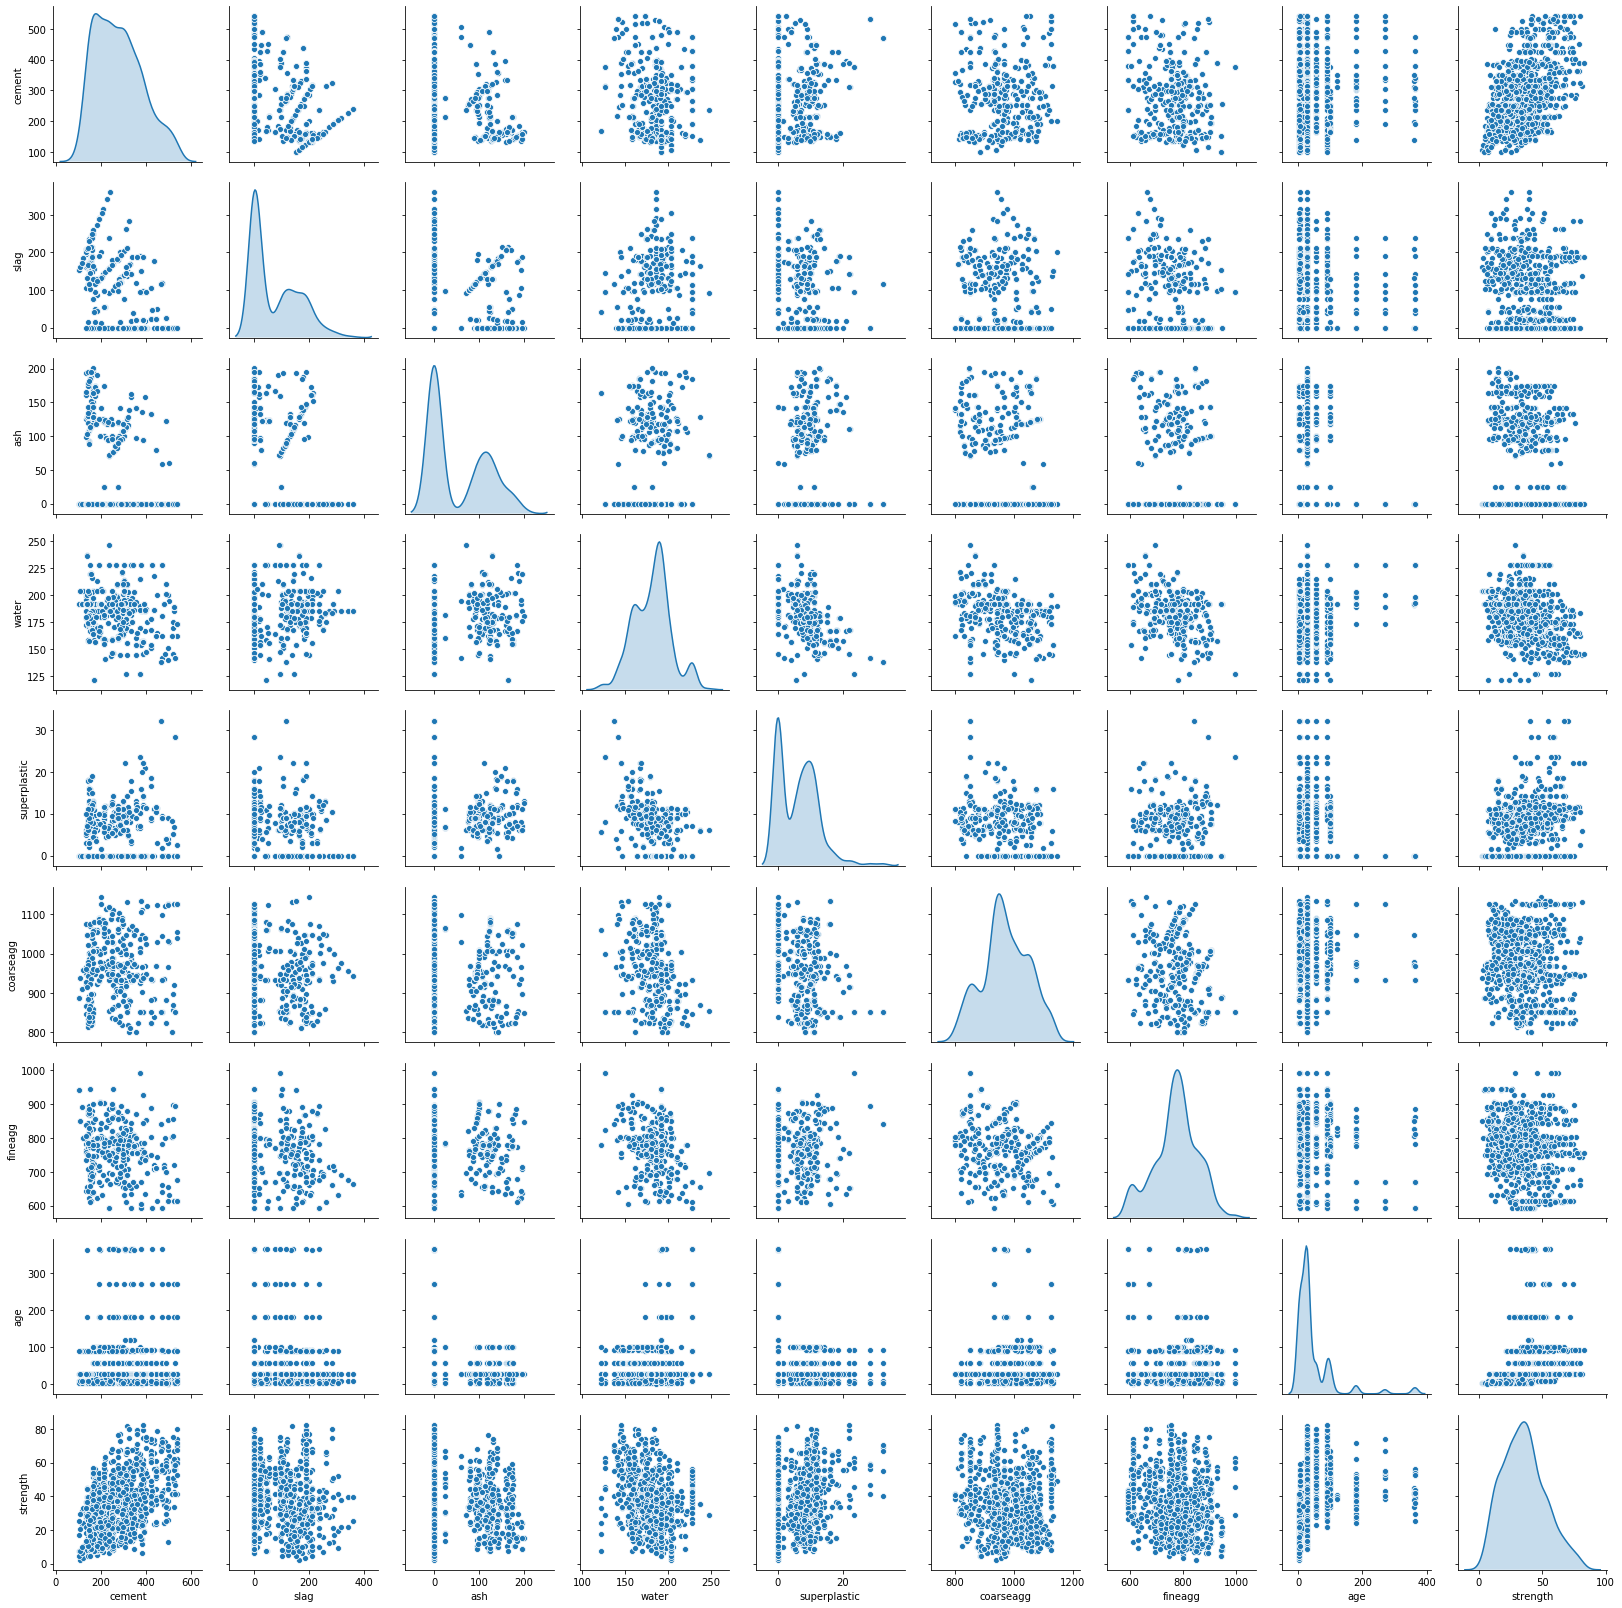

In [201]:
sns.pairplot(df, diag_kind='kde')

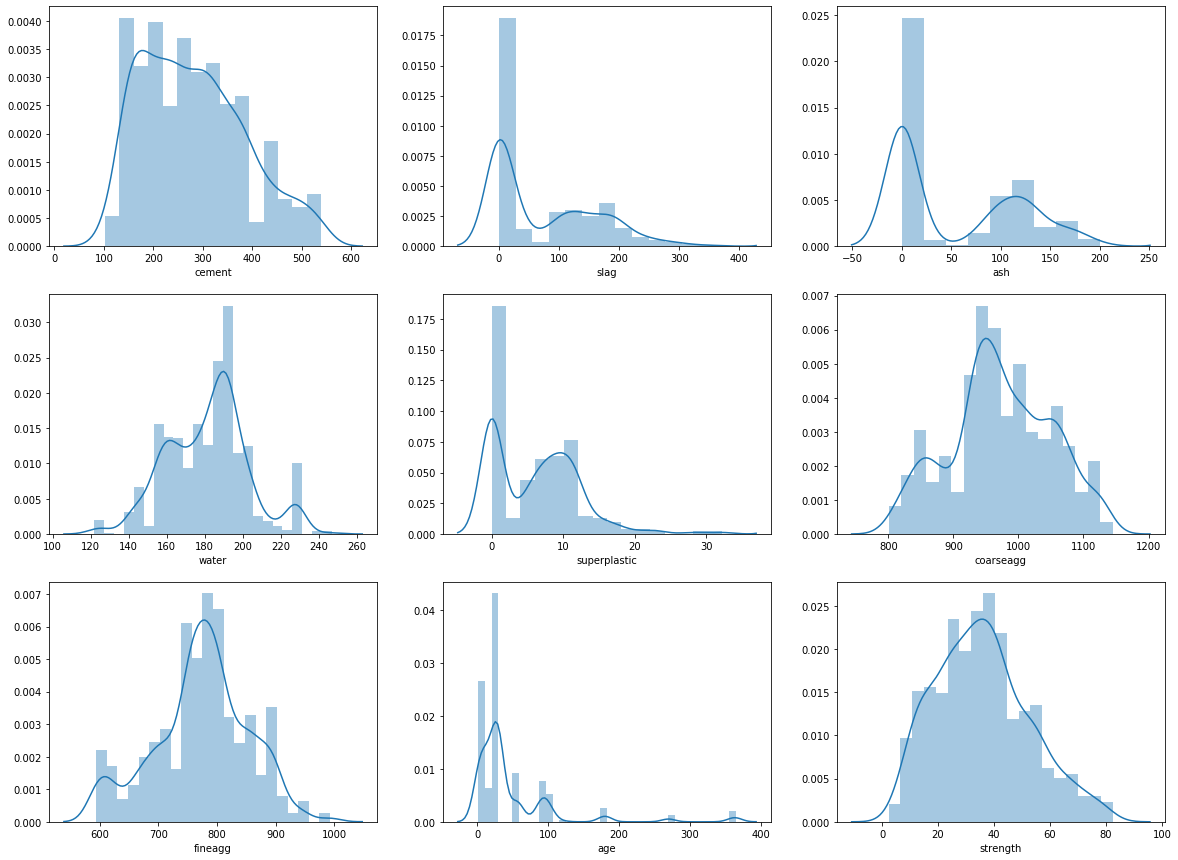

In [202]:
var=np.arange(1,len(df.columns)+1)
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.distplot(df.iloc[:,(i-1)])

some of the variables (super elastic,ash,superelastic)are displaying bi-modal distributions. Can explore adding a new variable for clustering.

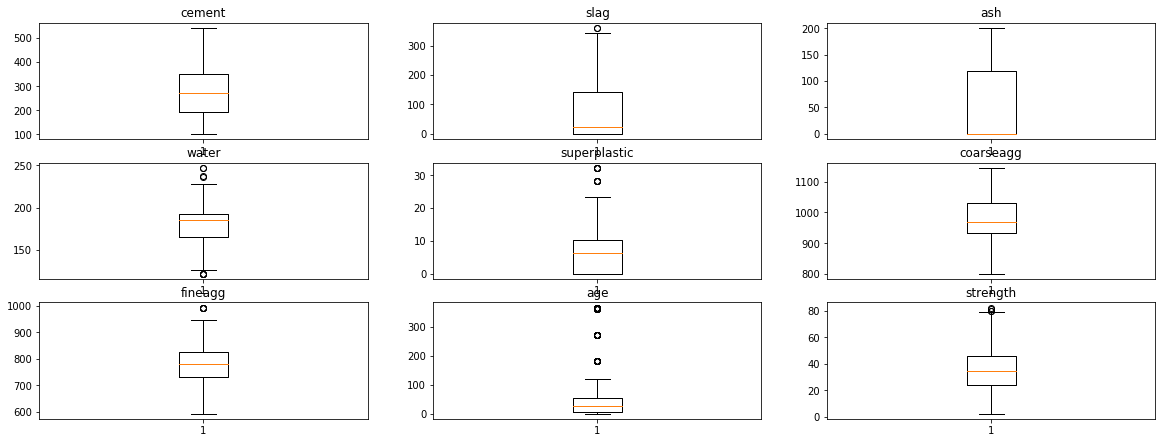

In [203]:
# Check for outliers
figsize(20, 15)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [3]:
Q1=np.percentile(df['slag'],25)
Q3=np.percentile(df['slag'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.slag=np.where(df.slag>UL, UL, df.slag)

In [4]:
Q1=np.percentile(df['fineagg'],25)
Q3=np.percentile(df['fineagg'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.fineagg=np.where(df.fineagg>UL, UL, df.fineagg)

In [5]:
Q1=np.percentile(df['water'],25)
Q3=np.percentile(df['water'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.water=np.where(df.water>UL, UL, df.water)

In [6]:
Q1=np.percentile(df['age'],25)
Q3=np.percentile(df['age'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.age=np.where(df.age>UL, UL, df.age)

In [7]:
Q1=np.percentile(df['superplastic'],25)
Q3=np.percentile(df['superplastic'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.superplastic=np.where(df.superplastic>UL, UL, df.superplastic)

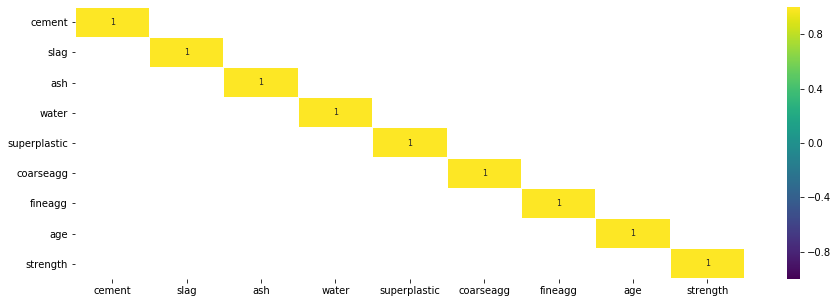

In [8]:
corr=df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.70) | (corr <= -0.70)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

In [9]:
#no major correlations amongst the variables and hence no multicollinearity expected to affect the performance of models

In [10]:
from sklearn.cluster import KMeans

In [11]:
cl=np.arange(1,9)
ess=[]
for i in cl:
    clust=KMeans(n_init=15,n_clusters=i)
    clust.fit(df.iloc[:,0:8])
    error=clust.inertia_
    ess.append(error)

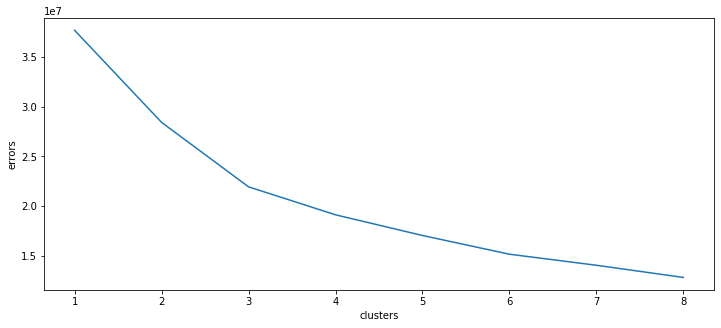

In [12]:
a=pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(a.clusters, a.errors)

In [13]:
#elbow seen at 3 clusters
clust=KMeans(n_init=15, n_clusters=3)
clust.fit(df.iloc[:,0:8])
df['cluster']=clust.predict(df.iloc[:,0:8])
df.cluster=pd.Categorical(df.cluster)

In [14]:
df.cluster.value_counts() , df.columns

(2    352
 0    341
 1    337
 Name: cluster, dtype: int64,
 Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
        'fineagg', 'age', 'strength', 'cluster'],
       dtype='object'))

In [15]:
X=df.iloc[:,[0,1,2,3,4,5,6,7,9]].values
y=df.strength.values

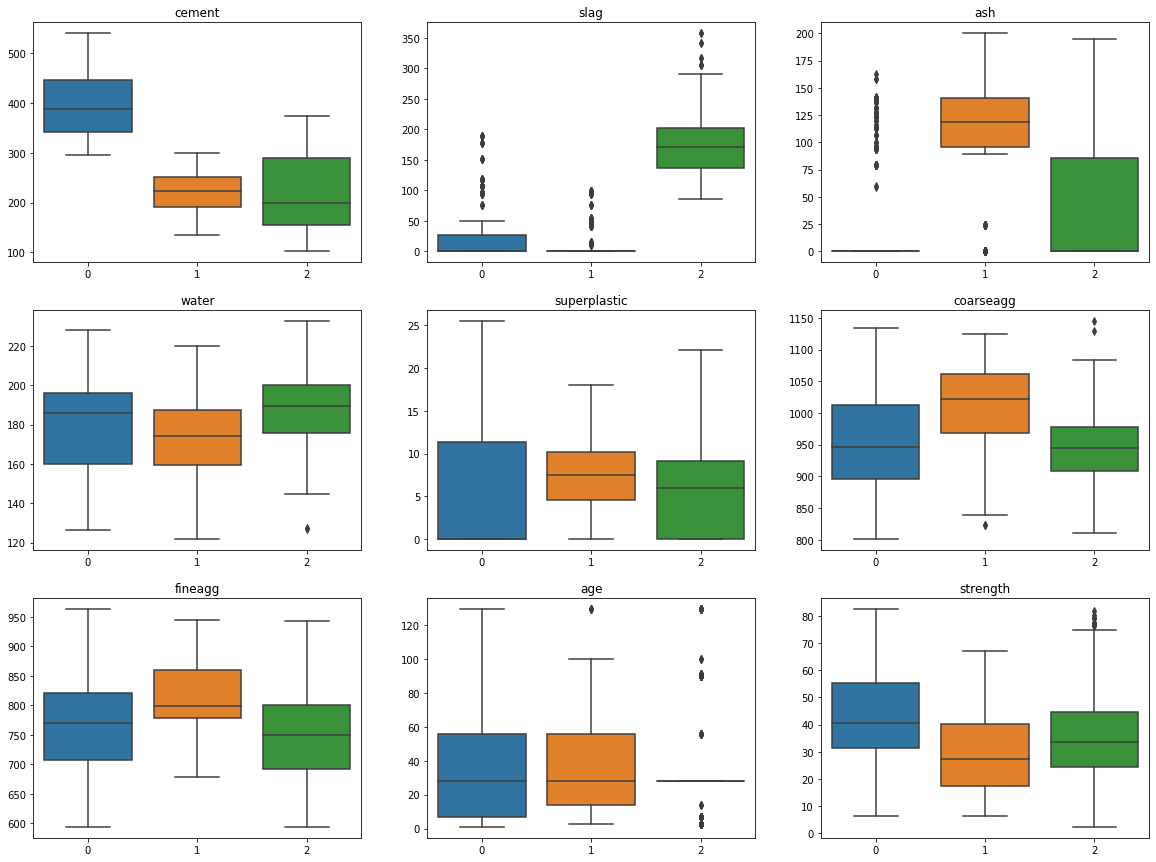

In [217]:
var=np.arange(1,len(df.columns))
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.boxplot(df.iloc[:,9],df.iloc[:,(i-1)])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(df.columns[i-1])

# There seems to be three distinct clusters, especially when we see the distribution for strength of cement.

There are a few more outliers when the distribution seen for each cluster which we may or may not want to treat depending on our model performances. We check below the performance of models with addition of the new variable i.e. cluster

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

In [17]:
k=len(df.columns)-1
n_valid=len(X_valid)
n_test=len(X_test)

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
def test(models, X,y, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [20]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.731025,0.728647,0.730337
1,0.714096,0.721394,0.715981


In [223]:
#Parameter tuning / Regularization introduced

In [21]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS':LinearRegression(),
           'Lasso': GridSearchCV(Lasso(),param_grid=lasso_params, cv=10).fit(X,y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv=10).fit(X, y).best_estimator_,}

test(models2, X,y)

,OLS,Lasso,Ridge
0,0.728474,0.729728,0.728901
1,0.724301,0.718948,0.722217


In [22]:
#Try the models without the new variable
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.729892,0.729633,0.729615
1,0.717025,0.716907,0.718192


# No major difference observed with regularization. Also the addition of cluster did not improve the results. So proceeding without the new column

In [35]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

In [36]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train,y_train)
Rid_gs.best_estimator_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [37]:
print(Rid_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Rid_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Rid_gs.predict(X_test))


Rsq_Adj_valid_RidGS= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_RidGS:%.2f'%Rsq_Adj_valid_RidGS)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_RidGS= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_RidGS:%.2f'%Rsq_Adj_test_RidGS)


MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-77.7568524403757
Rsq:0.72
Correlation_Validation: 0.848172127125031
Correlation_Test: 0.8554525213827938
Rsq_Adj_valid_RidGS:0.51
Rsq_Adj_test_RidGS:0.51
MAPE_RidGS:23.44


In [38]:
#Lasso

param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train,y_train)
Las_gs.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
print(Las_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Las_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Las_gs.predict(X_test))


Rsq_Adj_valid_Lasso= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_Lasso:%.2f'%Rsq_Adj_valid_Lasso)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_Lasso= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_Lasso:%.2f'%Rsq_Adj_test_Lasso)


MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

-77.7573948329207
Rsq:0.72
Correlation_Validation: 0.848192285273574
Correlation_Test: 0.8554904576274767
Rsq_Adj_valid_Lasso:0.51
Rsq_Adj_test_Lasso:0.51
MAPE_Lasso:23.45


In [40]:
Las_gs.best_estimator_.coef_

array([ 0.123154  ,  0.10526969,  0.07881589, -0.12884126,  0.31037712,
        0.01846245,  0.02423465,  0.24921579])

# No difference in performance of Ridge or Lasso models. Attempt to fit models by transforming the input variables to higher dimension

In [24]:
# Try with polynomial
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2)
X_train_tr=poly.fit_transform(X_train)
X_valid_tr=poly.fit_transform(X_valid)
X_test_tr=poly.fit_transform(X_test)


param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train_tr,y_train)
Rid_gs.best_estimator_

print(Rid_gs.best_score_ , Rid_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1]

MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test_tr))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-47.66986270809535 Ridge(alpha=45, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
Rsq:0.82
Correlation_Validation: 0.9086780159370893
Correlation_Test: 0.9183166198098076
MAPE_RidGS:16.59


# Improved performance with polynomial features of degree 2 which means the relationship between X and Y is non-linear and hence complex models may do better than simpler models. Ridge with Polynomial features so far has given the best results with least MAPE and highest adjusted Rsq

In [25]:

param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train_tr,y_train)

print(Las_gs.best_score_ , Las_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1]

MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test_tr))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

-48.19038717861418 Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Rsq:0.82
Correlation_Validation: 0.9078523521201673
Correlation_Test: 0.9170095975889396
MAPE_Lasso:16.69


In [43]:
# Almost identical results for both Ridge and Lasso is achieved. 

# Since the relationship between dependent and independent variables is non-linear, we could try to fit complex models to better capture the relationship. As the complexity of the models increases, the bias decreases but variance increases. However, in the initial stages, the rate of decrease in error due to bias is more than the rate of increase in variance error. Hence we need to find the right complexity which will give optimal results i.e. the lowest test error. Beyond the optimal point, the rate in increase in error due to variance overtakes the decrease in bias error and hence the total error goes up.

Try Tree based models with varying complexity to get the best estimator. SVM could also be tried. Also PCA alongwith clustering could be tried before Lasso and Ridge to see if there is improvement in performance

In [26]:
#Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor()

In [27]:
predictors=df.drop(['strength','cluster'], axis=1).columns
predictors

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

In [28]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Rsq (Train): 0.9608
Rsq (Validation): 0.8575
Rsq (Test): 0.8717
MAPE (Train): 8.502500
MAPE (Valid): 13.947752
MAPE (Test): 15.321778
Correlation Coeff (Test): 0.935751
CV Score : Mean - -38.73982 | Std - 12.62928 | Min - -72.55019 | Max - -27.04166


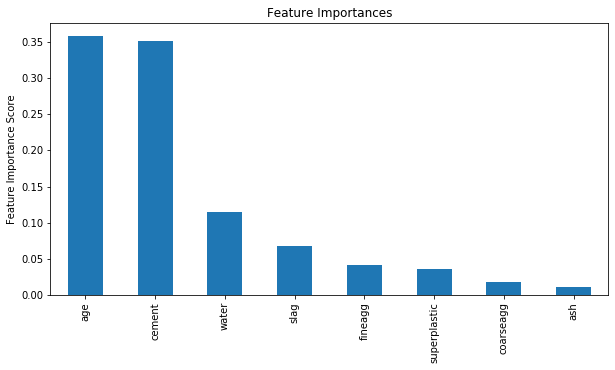

In [229]:
#Choose all predictors
plt.figure(figsize=(10,5))
modelfit(gbr, X_train, X_valid, X_test)

In [48]:
#Parameter tuning. Start with number of trees (n_estimators)
#Drop variables that are not significant as can be seen above (ash and coarseagg)

X=df.drop(['ash','coarseagg','strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['ash','coarseagg','strength', 'cluster'], axis=1).columns

param_test1 = {'n_estimators':range(20,150,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=15,min_samples_leaf=15,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 110}, -31.408157335027454)

In [49]:
#N_estimators is best at 110. Fix n_estimator and tune for max_depth alongwith mi_samples_split

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=110,
                                                               max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_


({'max_depth': 13, 'min_samples_split': 10}, -31.595809281496475)


Model Report
Rsq (Train): 0.9669
Rsq (Validation): 0.898
Rsq (Test): 0.9021
MAPE (Train): 7.407520
MAPE (Valid): 12.164973
MAPE (Test): 13.490996
Correlation Coeff (Test): 0.951202
CV Score : Mean - -31.59581 | Std - 8.9805 | Min - -56.03472 | Max - -23.28964


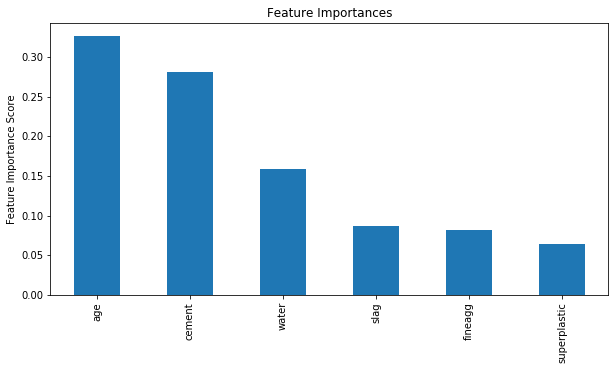

In [50]:
#replace maxdepth = 13 n min_samples_split=10. Check the performance
plt.figure(figsize=(10,5))
modelfit(gs2.best_estimator_,X_train, X_valid, X_test)

Text(0.5, 1.0, 'Actuals v Predicted')

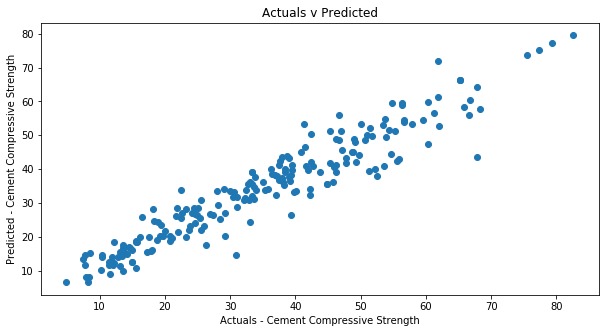

In [51]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs2.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

In [52]:
#Now lets tune the last tree-parameters, i.e. max_features by trying values from 3 to 7 in steps of 1.
param_test3 = {'max_features':range(3,7,1)}

gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=110,
                                                               max_depth=13,subsample=0.8,random_state=10,
                                                              min_samples_split=10),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs3=gsearch3.fit(X_train,y_train)
gs3.best_params_, gs3.best_score_

({'max_features': 3}, -34.3066023050513)


Model Report
Rsq (Train): 0.9706
Rsq (Validation): 0.9015
Rsq (Test): 0.9101
MAPE (Train): 6.953859
MAPE (Valid): 12.138427
MAPE (Test): 13.244881
Correlation Coeff (Test): 0.955298
CV Score : Mean - -34.3066 | Std - 8.557058 | Min - -57.08683 | Max - -25.60147


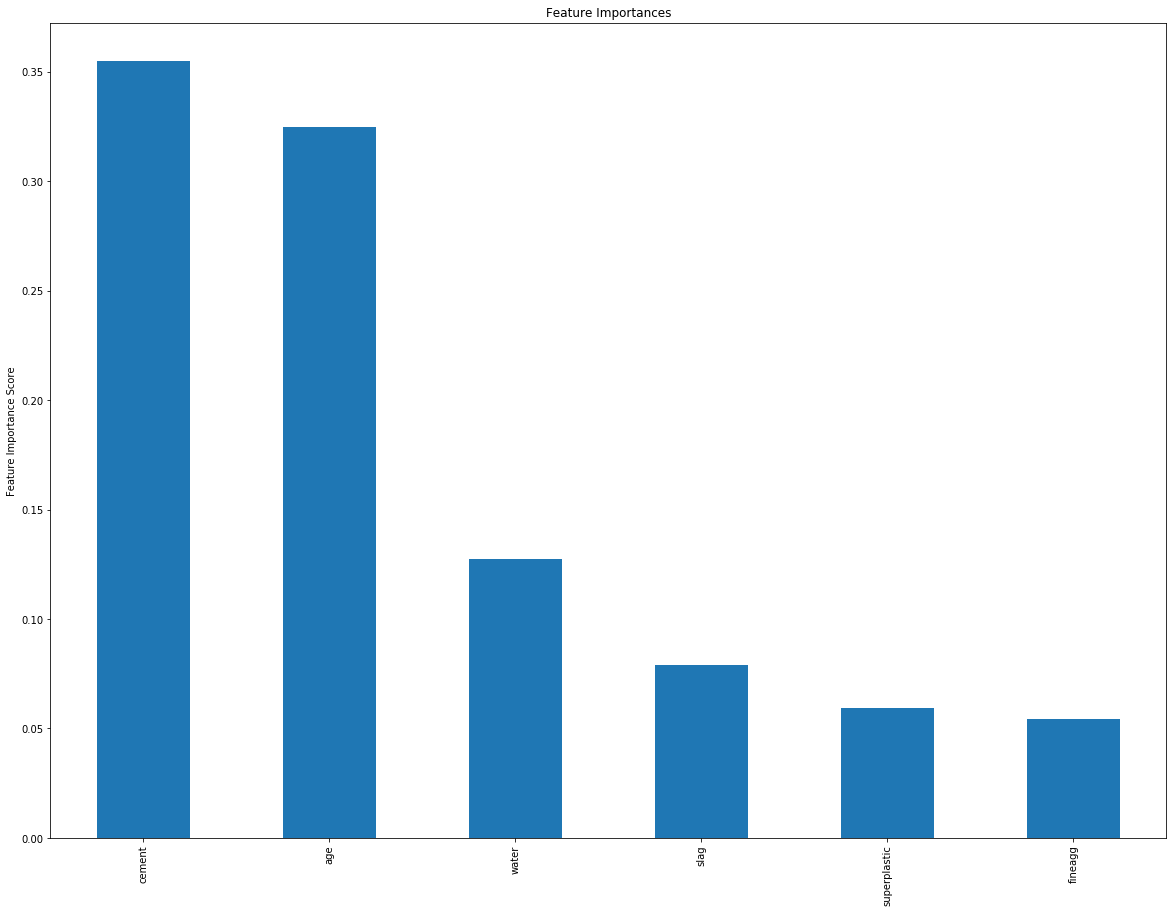

In [53]:
#replace max_features = 3 and Check the performance

modelfit(gs3.best_estimator_,X_train, X_valid, X_test)

In [54]:
#Slight improvement in performance is observed as can be seen by comparing the MAPE

Text(0.5, 1.0, 'Actuals v Predicted')

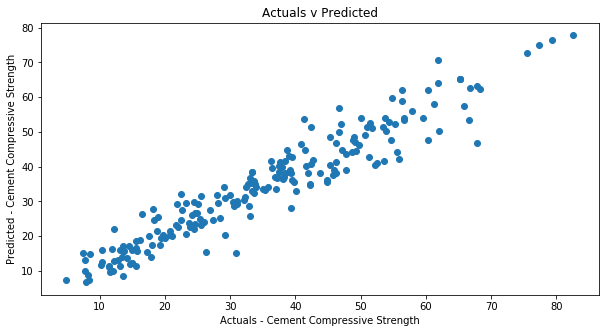

In [55]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs3.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

In [56]:
#Tuning subsample and making models with lower learning rate

param_test4 = {'subsample': [0.6,0.85,0.65,0.7,0.75,0.8]}
gridsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=110,
                                                               max_depth=13,random_state=10,min_samples_split=10,
                                                                max_features=3),
                        param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs4=gridsearch4.fit(X_train,y_train)
gs4.best_params_, gs4.best_score_

({'subsample': 0.85}, -33.714171007969355)


Model Report
Rsq (Train): 0.9731
Rsq (Validation): 0.8997
Rsq (Test): 0.894
MAPE (Train): 6.638142
MAPE (Valid): 12.040191
MAPE (Test): 13.572533
Correlation Coeff (Test): 0.946788
CV Score : Mean - -33.71417 | Std - 11.42235 | Min - -66.29 | Max - -23.84813


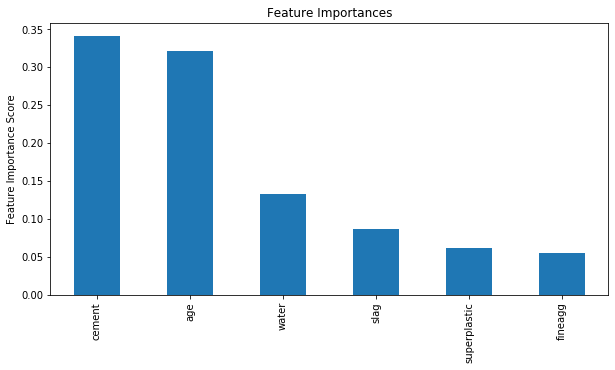

In [57]:
plt.figure(figsize=(10,5))
modelfit(gs4.best_estimator_, X_train, X_valid, X_test)


Model Report
Rsq (Train): 0.9743
Rsq (Validation): 0.8996
Rsq (Test): 0.9005
MAPE (Train): 6.511171
MAPE (Valid): 11.963218
MAPE (Test): 12.928393
Correlation Coeff (Test): 0.949985
CV Score : Mean - -33.72581 | Std - 10.02808 | Min - -61.29922 | Max - -26.0027


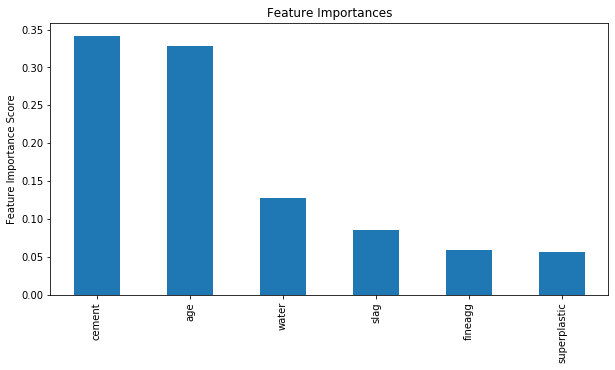

In [58]:
#Try lowering the learning rate and increase the number of trees simulataneously.

gbm_tuned= GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=13,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85)
                                     
plt.figure(figsize=(10,5))
modelfit(gbm_tuned, X_train,X_valid, X_test)

Text(0.5, 1.0, 'Actuals v Predicted')

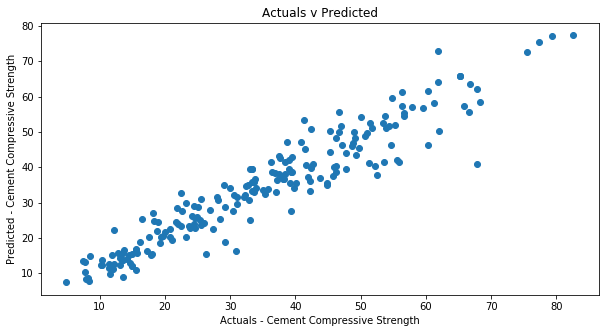

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gbm_tuned.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

#Best performance achieved with the tuned GBM model. However the model was trained and tuned on the original data. We saw that there is a non-linearship between X and Y.
Try the boosting model on transformed data

In [51]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))



modelfit(GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=13,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85), X_train_tr,X_valid_tr, X_test)


Model Report
Rsq (Train): 0.9757
Rsq (Validation): 0.8972
Rsq (Test): 0.8989
MAPE (Train): 6.280774
MAPE (Valid): 11.989813
MAPE (Test): 12.900591
Correlation Coeff (Test): 0.949640
CV Score : Mean - -33.13696 | Std - 9.180609 | Min - -58.99751 | Max - -24.5669


In [33]:
#Almost identical results with higher dimensional tranformation of independent variables

# Random Forest with Tuning


Model Report
Rsq (Train): 0.9741
Rsq (Validation): 0.825
Rsq (Test): 0.8442
MAPE (Train): 6.103681
MAPE (Valid): 15.733566
MAPE (Test): 15.471519
Correlation Coeff (Test): 0.921046
CV Score : Mean - -45.74255 | Std - 16.89775 | Min - -89.90582 | Max - -30.18447


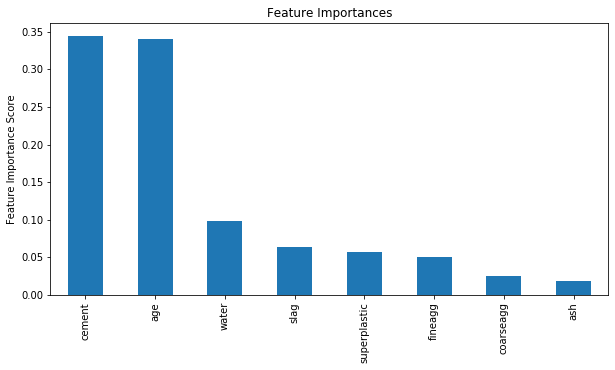

In [61]:
#Lets try the random forest with tuning as above. Start with all predictors

X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns
Rf_regressor1= RandomForestRegressor()
plt.figure(figsize=(10,5))
#Choose all predictors
modelfit(Rf_regressor1, X_train, X_valid, X_test)

In [62]:
#Parameter tuning starting with no. of trees along with Feature Selection

#Drop variables that are not significant as can be seen above (ash and coarseagg)

X=df.drop(['ash','coarseagg','strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['ash','coarseagg','strength','cluster'], axis=1).columns


param_test1 = {'n_estimators':range(20,150,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=15,min_samples_leaf=15, max_depth=8,
                                                          max_features='sqrt',random_state=10),
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 80}, -91.90154984366649)

In [63]:
#Fix n_estimators at 80. Tune for max depth and min_samples_split

param_test2 = {'max_depth':range(4,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(min_samples_leaf=15,n_estimators=80,
                                                               max_features='sqrt',random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_

({'max_depth': 8, 'min_samples_split': 10}, -91.90154984366649)


Model Report
Rsq (Train): 0.7467
Rsq (Validation): 0.6891
Rsq (Test): 0.7282
MAPE (Train): 26.608916
MAPE (Valid): 28.498786
MAPE (Test): 29.535779
Correlation Coeff (Test): 0.903818
CV Score : Mean - -91.90155 | Std - 28.54561 | Min - -159.6431 | Max - -59.65236


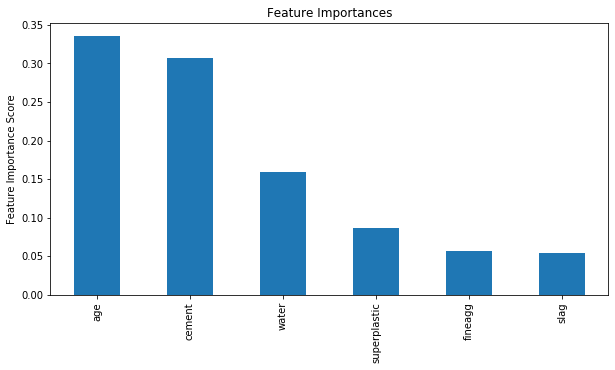

In [64]:
#Fix max_depth at 8 and min_samples_split at 10 and check perforamce
plt.figure(figsize=(10,5))
modelfit(gs2.best_estimator_,X_train, X_valid, X_test)

In [65]:
#Now lets tune the last tree-parameters, i.e. max_features and for min_samples_leaf
param_test3 = {'max_features':range(3,7,1), 'min_samples_leaf':range(10,100,10)}


gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=80,
                                                               max_depth=8,random_state=10, min_samples_split=10),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=10)
gs3=gsearch3.fit(X_train,y_train)
gs3.best_params_, gs3.best_score_

({'max_features': 4, 'min_samples_leaf': 10}, -61.701190765964085)


Model Report
Rsq (Train): 0.8509
Rsq (Validation): 0.7723
Rsq (Test): 0.8042
MAPE (Train): 18.285501
MAPE (Valid): 21.339673
MAPE (Test): 21.661260
Correlation Coeff (Test): 0.907537
CV Score : Mean - -61.70119 | Std - 20.21289 | Min - -109.4027 | Max - -39.76875


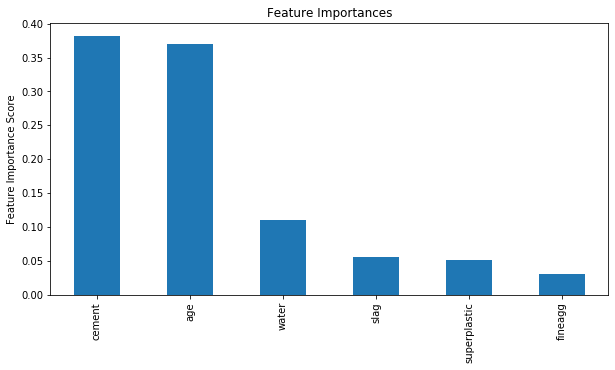

In [66]:
plt.figure(figsize=(10,5))
modelfit(gs3.best_estimator_, X_train,X_valid, X_test)

#The best results were achieved without any tuning and feature selection with the random forest regressor. Let's put the removed variables back to compare performace


Model Report
Rsq (Train): 0.8404
Rsq (Validation): 0.7633
Rsq (Test): 0.7981
MAPE (Train): 19.486276
MAPE (Valid): 22.775749
MAPE (Test): 22.916583
Correlation Coeff (Test): 0.909193
CV Score : Mean - -65.12647 | Std - 21.68684 | Min - -119.3547 | Max - -42.99047


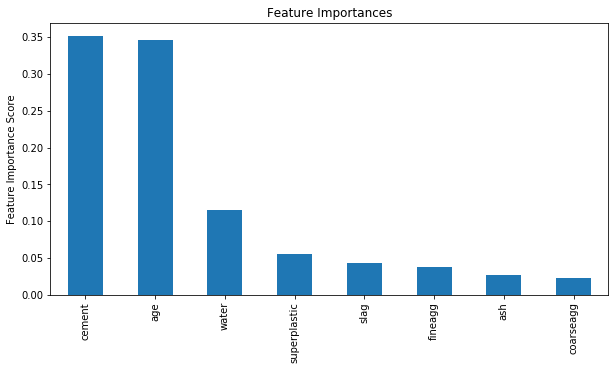

In [67]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns
Rf_regressor= RandomForestRegressor(n_estimators=80,max_depth=8,random_state=10, min_samples_split=10, max_features=4,
                                   min_samples_leaf=10)
plt.figure(figsize=(10,5))
#Choose all predictors
modelfit(Rf_regressor, X_train, X_valid, X_test)

#The random forest regressor without any feature selection and any tuning gave the best results amongst all random forest models build. The tuned boosting model though has given the best results.

Text(0.5, 1.0, 'Actuals v Predicted')

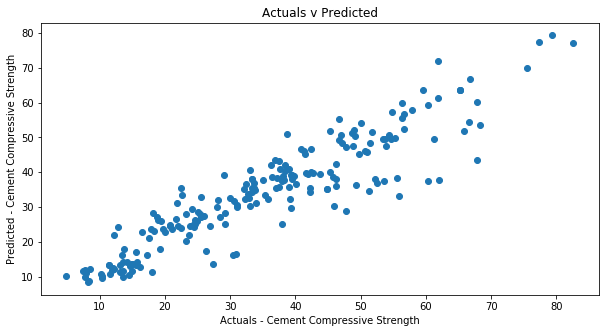

In [68]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, Rf_regressor1.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

# Try XGBoost with Tuning

In [86]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'], axis=1).columns
Xgb_regressor= XGBRegressor()

In [87]:
def modelfit(alg, dtrain,dvalid,dtest ,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='rmse')
    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
        
        
    #Print model report:
    print ("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])

In [72]:
#In order to decide on boosting parameters, we need to set some initial values of other parameters.

xgb1 = XGBRegressor(booster='gbtree',
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, X_valid, X_test,predictors)

[09:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.999
Rsq (Validation): 0.8836
Rsq (Test): 0.886
MAPE (Train): 1.027254
MAPE (Valid): 11.263813
MAPE (Test): 12.015303
Correlation Coeff (Test): 0.943080


In [73]:
#Tune max_depth and min_child_weight

param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

[09:34:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 4, 'min_child_weight': 1}, -34.03589393116901)

In [74]:
modelfit(gsearch1.best_estimator_, X_train,X_valid,X_test, predictors)

[09:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9782
Rsq (Validation): 0.8836
Rsq (Test): 0.8884
MAPE (Train): 6.389113
MAPE (Valid): 12.210926
MAPE (Test): 13.219236
Correlation Coeff (Test): 0.944863


In [75]:
#Tune gamma

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch1.best_score_

[09:34:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.2}, -34.03589393116901)

In [76]:
#Tune subsample and colsample_bytree

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, gamma=0,min_child_weight=1,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch1.best_score_

[09:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.8, 'subsample': 0.8}, -34.03589393116901)

In [77]:
#Tuning Regularization Parameters

param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch1.best_score_

[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 0.1}, -34.03589393116901)

In [78]:
modelfit(gsearch4.best_estimator_, X_train,X_valid,X_test, predictors)

[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9793
Rsq (Validation): 0.8835
Rsq (Test): 0.8893
MAPE (Train): 6.189916
MAPE (Valid): 12.360135
MAPE (Test): 13.376082
Correlation Coeff (Test): 0.945215


In [79]:
param_test5 = {
 'reg_alpha':[0.07,0.08,0.09,0.1,0.11,0.12]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=1000,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch1.best_score_

[09:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1e-05}, -34.03589393116901)

In [80]:
modelfit(gsearch5.best_estimator_, X_train,X_valid,X_test, predictors)

[09:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.998
Rsq (Validation): 0.8904
Rsq (Test): 0.8844
MAPE (Train): 1.770646
MAPE (Valid): 10.927956
MAPE (Test): 12.409929
Correlation Coeff (Test): 0.942143


In [81]:
# Since the first XGB model produced the least MAPE, we could try Reducing Learning Rate for the first model and double the no. of estimators

XGB=XGBRegressor( booster='gbtree', learning_rate =0.05, n_estimators=2000,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1,reg_alpha=0.1 ,seed=27)

modelfit(XGB, X_train,X_valid, X_test, predictors)

[09:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9973
Rsq (Validation): 0.897
Rsq (Test): 0.8958
MAPE (Train): 2.063509
MAPE (Valid): 10.703068
MAPE (Test): 12.070784
Correlation Coeff (Test): 0.947510


The best results are achieved through the fully tuned gbm model and the XGB model above. XGB gives slightly better results but the computation time is a little more. Any of the two models can be used in production

In [82]:
#Try Support Vector Machine
X=df.drop(['strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength', 'cluster'], axis=1).columns

In [83]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)    
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [84]:
param_grid = {'kernel': ['rbf','sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4],'C': [0.1, 10, 25]}

gsearch1 = GridSearchCV(estimator = SVR(),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gs1=gsearch1.fit(X_train,y_train)
print(gs1.best_params_, gs1.best_score_)

print("Correlation_Validation:", np.corrcoef(y_valid,gs1.predict(X_valid))[0,1])
print("Correlation_Test:", np.corrcoef(y_test,gs1.predict(X_test))[0,1])

Rsq_valid=r2_score(y_valid,gs1.predict(X_valid))
Rsq_test=r2_score(y_test,gs1.predict(X_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_RidGS:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,gs1.predict(X_test))
print('MAPE_RidGS:%.2f' %MAPE_Test)

{'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'} -72.61380735805264
Correlation_Validation: 0.8717336450923483
Correlation_Test: 0.8905955261057161
Rsq_Adj_valid:0.55
Rsq_Adj_test_RidGS:0.61
MAPE_RidGS:22.32


In [97]:
param_grid = {'kernel': ['rbf'], 'gamma': [0.0001,0.000025,0.0000125,0.0000125/2,0.0000125/4],
              'C': [750,1000,1150,1175,1200,1225]}

gsearch2 = GridSearchCV(estimator = SVR(),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gs2=gsearch2.fit(X_train,y_train)
print(gs2.best_params_, gs2.best_score_)

print("Correlation_Validation:", np.corrcoef(y_valid,gs2.predict(X_valid))[0,1])
print("Correlation_Test:", np.corrcoef(y_test,gs2.predict(X_test))[0,1])

Rsq_valid=r2_score(y_valid,gs2.predict(X_valid))
Rsq_test=r2_score(y_test,gs2.predict(X_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,gs2.predict(X_test))
print('MAPE_SVR:%.2f' %MAPE_Test)

{'C': 1200, 'gamma': 1.25e-05, 'kernel': 'rbf'} -37.39730317423556
Correlation_Validation: 0.9207407480179899
Correlation_Test: 0.9176778159765042
Rsq_Adj_valid:0.71
Rsq_Adj_test:0.69
MAPE_SVR:16.43


In [89]:
#With Multiple iterations of the rbf kernel grid search, the best model achieved is with the above hyperparameters

In [137]:
#Try stacking


from vecstack import stacking

models = [
    GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,max_depth=13,random_state=10,
                              min_samples_split=10,max_features=3,subsample=0.85),
        
    RandomForestRegressor(),
        
    XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27),
    gsearch2.best_estimator_ , #Support Vector Regressor
    Las_gs.best_estimator_ #Lasso model tried earlier
            
]

In [160]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[10:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [161]:
#The beta model is below

model = Ridge()

model = model.fit(S_train, y_train)


Rsq_test=r2_score(y_test,model.predict(S_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,model.predict(S_test))
print('MAPE_stackedModels:%.2f' %MAPE_Test)

Rsq_Adj_valid:0.71
Rsq_Adj_test:0.88
MAPE_stackedModels:9.11


Text(0.5, 1.0, 'Actuals v Predicted')

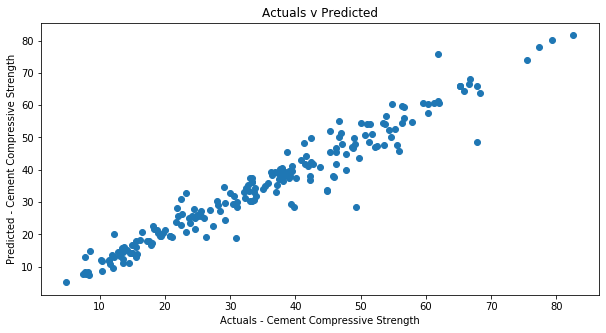

In [162]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, model.predict(S_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

# The best output achieved of all models tried is with the stacked model just above. A MAPE of less than 10% is achieved for the first time across all models tried. XGBoost and Gradient Boosting were the 2nd best. Randomforest and simpler regularized linear models like ridge and lasso were not very far off.

# Surprisingly the computational time is not as high for the most complex model tried i.e. the stacked ensemble model with a Ridge model as the meta regressor. So we should choose the stacked ensemble model to be employed in production for the best results.